# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
from pyspark.sql import SparkSession

# Data Exploration
#from datetime import datetime, timedelta
import pandas as pd
pd.set_option('display.max_colwidth', -1)
#import plotly.graph_objs as go
#from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
%matplotlib inline
from pyspark.sql.functions import avg, concat, count, countDistinct, \
                                  col, datediff, date_format, desc, \
                                  format_number, isnan, lag, lit, split, udf
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import round as Fround
from pyspark.sql.functions import mean as Fmean
from pyspark.sql import Window

# Feature Engineering
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.sql.types import StructField, StructType, IntegerType, FloatType, StringType
from pyspark.ml.stat import Summarizer

# Modeling
from pyspark.sql.functions import split
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("Sparkify Churn Prediction - Bunn") \
        .getOrCreate() 

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Load the Sparkify Events data from a JSON file into a Spark DataFrame
path_to_data = 'mini_sparkify_event_data.json'
sparkify_events_df = spark.read.json(path_to_data)

In [4]:
# Function for initial data exploration

def initial_data_exploration(df):
    '''
    Display some initial information about the DataFrame
    
    - Input:
        - df: the DataFrame
    '''
    # Data Structure
    print('\n> Schema\n  ______\n')
    sparkify_events_df.printSchema()
    
    # Sample Record
    print('\n> Sample Data Record\n  __________________\n')
    print(sparkify_events_df.head())
    
    # Shape
    print('\n> The Sparkify data set is composed of {} records and {} features.\n  ___________'.format(sparkify_events_df.count(),
                                                                                                       len(sparkify_events_df.columns)))
    
    # Identify Categorical and Numerical features
    categorical_features = []
    numerical_features = []
    
    for i in range(len(df.dtypes)):
        feature_type = df.dtypes[i][1]
        feature_label = df.dtypes[i][0]
        
        if feature_type == 'string':
            categorical_features.append(feature_label)
        else:
            numerical_features.append(feature_label)
            
    print('\n> Categorical Features\n  ____________________\n\n', categorical_features)
    print('\n> Numerical Features:\n  __________________\n\n', numerical_features)

In [5]:
initial_data_exploration(sparkify_events_df)


> Schema
  ______

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)


> Sample Data Record
  __________________

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessio

In [6]:
# Unique values for a given feature
def display_unique_values(df, label, limited):
    '''
    Prints all unique values in the DataFrame's column
    
    - Input:
        - df: the DataFrame
        - label: the column label
        - limited: if True limits the number of rows printed (20 by default)
    '''
    distinct_vals = df.select(label).dropDuplicates().sort(label)
    distinct_vals.show(20 if limited else df.count(), False)
    print('> {} elements\n\n'.format(distinct_vals.count()))

In [7]:
display_unique_values(sparkify_events_df, 'userId', True)
display_unique_values(sparkify_events_df, 'auth', False)
display_unique_values(sparkify_events_df, 'gender', False)
display_unique_values(sparkify_events_df, 'level', False)
display_unique_values(sparkify_events_df, 'location', True)
display_unique_values(sparkify_events_df, 'method', False)
display_unique_values(sparkify_events_df, 'page', False)
display_unique_values(sparkify_events_df, 'userAgent', True)
display_unique_values(sparkify_events_df, 'status', False)

+------+
|userId|
+------+
|      |
|10    |
|100   |
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows

> 226 elements


+----------+
|auth      |
+----------+
|Cancelled |
|Guest     |
|Logged In |
|Logged Out|
+----------+

> 4 elements


+------+
|gender|
+------+
|null  |
|F     |
|M     |
+------+

> 3 elements


+-----+
|level|
+-----+
|free |
|paid |
+-----+

> 2 elements


+-------------------------------------+
|location                             |
+-------------------------------------+
|null                                 |
|Albany, OR                           |
|Albany-Schenectady-Troy, NY          |
|Alexandria, LA                       |
|Allentown-Bethlehem-Easton, PA-NJ    |
|Anchorage, AK                        |
|Atlanta-Sandy Springs-Roswell, GA    |
|Atlantic City-Hammonton, NJ          |
|Austin-Round Rock, TX                

In [8]:
# Missing values per feature
def missing_values(df):
    '''
    Print the number of missing values for each feature in the DataFrame
    - Input:
        - df: the DataFrame
    '''
    print('\n> Missing values by Feature\n  _________________________\n')
    
    for feature in df.columns:
        num_missing = df.filter((df[feature] == "") | df[feature].isNull() | isnan(df[feature])).count()
        print('{0:20}: {1}'.format(feature, num_missing))

In [9]:
missing_values(sparkify_events_df)


> Missing values by Feature
  _________________________

artist              : 58392
auth                : 0
firstName           : 8346
gender              : 8346
itemInSession       : 0
lastName            : 8346
length              : 58392
level               : 0
location            : 8346
method              : 0
page                : 0
registration        : 8346
sessionId           : 0
song                : 58392
status              : 0
ts                  : 0
userAgent           : 8346
userId              : 8346


### Drop empty user IDs ###
Regardless of the reason (logged out, unregistered...), **empty userIds** and **sessionIds** (none in this limited data set) are useless for the purpose of detecting potentially churning users, so we can **delete** the corresponding records.

In [10]:
def drop_empty_by_feature(df, column):
    """
    Returns a DataFrame without null/NaN/empty values in the column.
    
    - Input:
        - df: the DataFrame
        - column: the column of the DataFrame where we'll be looking for null/NaN/empty values
    
    - Output:
        - clean_df: the original DataFrame cleared of all rows containing a null/NaN/empty value for the passed-in feature
    """
    #print('Shape before dropping: {} x {}'.format(df.count(), len(df.columns)))
    # Determine if the column type is a string ??? IS THERE A DIRECT WAY TO FIND THE TYPE OF A COLUMN BY NAME ???
    for col in range(len(df.dtypes)):
        if sparkify_events_df.dtypes[col][0] == column:
            if df.dtypes[col][1] == 'string':
                str_col = True
            else:
                str_col = False
            break
    
    if str_col:
        clean_df = df.filter((df[column] != "") & df[column].isNotNull() & ~isnan(df[column]))
    else:
        clean_df = df.filter(df[column].isNotNull() & ~isnan(df[column]))
    
    return clean_df

In [11]:
# Clean userId and sessionId of all null/NaN/empty values
sparkify_events_clean_df = drop_empty_by_feature(sparkify_events_df, 'userId')
sparkify_events_clean_df = drop_empty_by_feature(sparkify_events_clean_df, 'sessionId')

In [12]:
missing_values(sparkify_events_clean_df)


> Missing values by Feature
  _________________________

artist              : 50046
auth                : 0
firstName           : 0
gender              : 0
itemInSession       : 0
lastName            : 0
length              : 50046
level               : 0
location            : 0
method              : 0
page                : 0
registration        : 0
sessionId           : 0
song                : 50046
status              : 0
ts                  : 0
userAgent           : 0
userId              : 0


**All empty data** was linked to the **missing userIds**!

In [13]:
print('\n> The Sparkify data set is now composed of {} records and {} features.\n  ___________'.format(sparkify_events_clean_df.count(),
                                                                                                       len(sparkify_events_clean_df.columns)))


> The Sparkify data set is now composed of 278154 records and 18 features.
  ___________


All **null** values associated with **null userIds** have now disappeared (*e.g.*, no more **null** value for **gender**. The remaining **nulls** apply to **artist**/**song**/**length**; let's verify that **NextSong** is the only task associated with these 3 features when they are present.

In [14]:
artists_df = sparkify_events_clean_df.filter((sparkify_events_clean_df['artist'] != "") & \
                                             ~sparkify_events_clean_df['artist'].isNull() & \
                                             ~isnan(sparkify_events_clean_df['artist']))
display_unique_values(artists_df, 'page', False)

+--------+
|page    |
+--------+
|NextSong|
+--------+

> 1 elements




### Removing Features ###
- Given the **high ratio** between distinct values of **location** and **userAgent** on one hand and of **userId** on the other hand, it makes sense to remove these 2 features from this limited data set. They may be useful later when working with the full data set on a Spark cluster.
- **method** and **status** are related to the HTTP protocol and can be removed here.
- We'll define churn based on **page** '*Cancellation Confirmation*', so we can remove **auth**.
- The user's first and last names are irrelevant.

In [15]:
sparkify_events_clean_df = sparkify_events_clean_df.drop('location', 'userAgent', 'method', 'status', 'auth', 'firstName', 'lastName')

In [16]:
sparkify_events_clean_df.toPandas().head()    # Turning into a Pandas DataFrame for display purposes only; this would be removed outside of a Jupyter Notebook

,artist,gender,itemInSession,length,level,page,registration,sessionId,song,ts,userId
0,Martha Tilston,M,50,277.89016,paid,NextSong,1538173362000,29,Rockpools,1538352117000,30
1,Five Iron Frenzy,M,79,236.09424,free,NextSong,1538331630000,8,Canada,1538352180000,9
2,Adam Lambert,M,51,282.82730,paid,NextSong,1538173362000,29,Time For Miracles,1538352394000,30
3,Enigma,M,80,262.71302,free,NextSong,1538331630000,8,Knocking On Forbidden Doors,1538352416000,9
4,Daft Punk,M,52,223.60771,paid,NextSong,1538173362000,29,Harder Better Faster Stronger,1538352676000,30


### Add Date/Time information ###
Convert the **ts** column's **timestamps** into **human-readable** formats, such as **date**, **year**, **month**, **day**, **hour**, **weekday**, and **week number**.

In [17]:
def ts_to_date_time(df, timestamp_col):
    '''
    Converts a timestamp in milliseconds to human-readable formats: date, year, month, day, hour, weekday, and week number.
    The original timestamp column is retained, because it can be used to perform operations, such as deltas.
        
    - Input:
        - df: the DataFrame containing the timestamp column
        - timestamp_col: the name of the timestamp column
        
    - Output:
        - date_time_df: the dataframe with the new date & time columns
    '''
    
    ts = (df[timestamp_col]/1000.0).cast('timestamp')

    date_time_df = df.withColumn("{}_date".format(timestamp_col), date_format(ts, format='yyyy-MM-dd')) \
                     .withColumn("{}_year".format(timestamp_col), date_format(ts, format='y')) \
                     .withColumn("{}_month".format(timestamp_col), date_format(ts, format='M')) \
                     .withColumn("{}_day".format(timestamp_col), date_format(ts, format='d')) \
                     .withColumn("{}_hour".format(timestamp_col), date_format(ts, format='H')) \
                     .withColumn("{}_weekday".format(timestamp_col), date_format(ts, format='u')) \
                     .withColumn("{}_week_#".format(timestamp_col), date_format(ts, format='w'))
    
    return date_time_df

In [18]:
sparkify_events_clean_df = ts_to_date_time(sparkify_events_clean_df, 'ts')

In [19]:
sparkify_events_clean_df.toPandas().head()

,artist,gender,itemInSession,length,level,page,registration,sessionId,song,ts,userId,ts_date,ts_year,ts_month,ts_day,ts_hour,ts_weekday,ts_week_#
0,Martha Tilston,M,50,277.89016,paid,NextSong,1538173362000,29,Rockpools,1538352117000,30,2018-10-01,2018,10,1,2,1,40
1,Five Iron Frenzy,M,79,236.09424,free,NextSong,1538331630000,8,Canada,1538352180000,9,2018-10-01,2018,10,1,2,1,40
2,Adam Lambert,M,51,282.82730,paid,NextSong,1538173362000,29,Time For Miracles,1538352394000,30,2018-10-01,2018,10,1,2,1,40
3,Enigma,M,80,262.71302,free,NextSong,1538331630000,8,Knocking On Forbidden Doors,1538352416000,9,2018-10-01,2018,10,1,2,1,40
4,Daft Punk,M,52,223.60771,paid,NextSong,1538173362000,29,Harder Better Faster Stronger,1538352676000,30,2018-10-01,2018,10,1,2,1,40


In [20]:
def delta_ts(timestamp_min, timestamp_max, unit='ms'):
    '''
    Calculate the time difference between 2 timestamps in milliseconds.
    
    - Input:
        - ts_min: minimum timestamp
        - ts_max: maximum timestamp
        - unit: one of 'ms' (default), 's', 'min', 'hour', 'day', 'week', 'month', 'year'
    
    - Output:
        - delta: the time difference in the requested unit
    '''
    delta = timestamp_max - timestamp_min
    
    if (unit == 's'):
        delta /= 1000
    elif (unit == 'min'):
        delta /= (1000*60)
    elif (unit == 'hour'):
        delta /= (1000*60*60)
    elif (unit == 'day'):
        delta /= (1000*60*60*24)
    elif (unit == 'week'):
        delta /= (1000*60*60*24*7)
    elif (unit == 'month'):
        delta /= (1000*60*60*24*30)
    elif (unit == 'year'):
        delta /= (1000*60*60*24*365)
        
    return delta

In [21]:
sparkify_events_clean_df.describe('ts').show()
ts_min = sparkify_events_clean_df.agg({'ts': 'min'}).collect()[0][0]
ts_max = sparkify_events_clean_df.agg({'ts': 'max'}).collect()[0][0]
print('The entire data set spans {} - {} ms = {:.2f} days.'.format(ts_max, ts_min, delta_ts(ts_min, ts_max, unit='day')))

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              278154|
|   mean|1.540958915431790...|
| stddev|1.5068287123356583E9|
|    min|       1538352117000|
|    max|       1543799476000|
+-------+--------------------+

The entire data set spans 1543799476000 - 1538352117000 ms = 63.05 days.


### Limited Timespan ###
Based on this **limited timespan**, we know that this data set won't enable us to look to far into the future for anticipating churn. A few **days** will be our best bet here.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [22]:
def define_churn(df):
    '''
    Creates 6 additional columns:
        - 'churn_cancel': 1 if service is cancelled, 0 otherwise
        - 'phase_cancel': 1 up until the cancellation, 0 after
        - 'cancelled_user': 1 for all events of a user who has eventually cancelled
        - 'churn_downgrade': 1 if service is downgraded from paid to free, 0 otherwise
        - 'phase_downgrade': 1 up until the downgrade, 0 after
        - 'downgraded_user': 1 for all events of a user who has eventually downgraded
        
    - Input:
        - df: the DataFrame
    
    - Output:
        - churn_df: the DataFrame with with the 2 additional churn features
    '''      
    
    # 2 flagging functions
    flag_cancel_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
    flag_downgrade_event = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
    
    # Flag Service Cancellation and Downgrade
    churn_df = df.withColumn('churn_cancel', flag_cancel_event('page')) \
                 .withColumn('churn_downgrade', flag_downgrade_event('page'))
    
    # Extend the flags to events prior to churn event
    pre_churn_window = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)
    churn_df = churn_df.withColumn('phase_cancel', Fsum('churn_cancel').over(pre_churn_window)) \
                       .withColumn('phase_downgrade', Fsum('churn_downgrade').over(pre_churn_window))
    
    # Flag all of the user's events
    churn_df = churn_df.withColumn('cancelled_user', Fmax('churn_cancel').over(Window.partitionBy('userId'))) \
                       .withColumn('downgraded_user', Fmax('churn_downgrade').over(Window.partitionBy('userId')))
    
    # Order the DataFrame by user ID and timestamp
    churn_df = churn_df.orderBy('userId', 'ts')
    
    return churn_df

In [23]:
sparkify_churn_df = define_churn(sparkify_events_clean_df)

### Take a look at the activity of a **churning** user and of a **downgrading** user ###
The former no longer interacts with the service after cancellation, which is why all values in '*phase_cancel*' are **1**.

The latter has a pre-downgrade phase with '*phase_downgrade*' = 1 and a post-downgrade phase with '*phase_downgrade*' = 0.

In [24]:
sparkify_churn_df.select(['userId', 'page', 'churn_cancel', 'phase_cancel', 'cancelled_user']) \
                 .where((sparkify_churn_df['userId'] == '125') &
                        (sparkify_churn_df['cancelled_user'] == 1)).toPandas()

,userId,page,churn_cancel,phase_cancel,cancelled_user
0,125,NextSong,0,1,1
1,125,NextSong,0,1,1
2,125,NextSong,0,1,1
3,125,NextSong,0,1,1
4,125,NextSong,0,1,1
5,125,NextSong,0,1,1
6,125,NextSong,0,1,1
7,125,NextSong,0,1,1
8,125,Roll Advert,0,1,1
9,125,Cancel,0,1,1


In [25]:
sparkify_churn_df.select(['userId', 'page', 'churn_downgrade', 'phase_downgrade', 'downgraded_user']) \
                 .where((sparkify_churn_df['userId'] == '96') &
                        (sparkify_churn_df['downgraded_user'] == 1)).toPandas()[1280:1300]

,userId,page,churn_downgrade,phase_downgrade,downgraded_user
1280,96,Thumbs Up,0,1,1
1281,96,NextSong,0,1,1
1282,96,NextSong,0,1,1
1283,96,NextSong,0,1,1
1284,96,Add to Playlist,0,1,1
1285,96,NextSong,0,1,1
1286,96,NextSong,0,1,1
1287,96,NextSong,0,1,1
1288,96,NextSong,0,1,1
1289,96,Downgrade,0,1,1


In [26]:
num_total_users = sparkify_churn_df.select('userId').dropDuplicates().count()
num_downgraded_users = sparkify_churn_df.select('userId').dropDuplicates() \
                                        .where(sparkify_churn_df['downgraded_user'] == 1).count()
num_cancelled_users = sparkify_churn_df.select('userId').dropDuplicates() \
                                       .where(sparkify_churn_df['cancelled_user'] == 1).count()
num_downgraded_and_cancelled_users = sparkify_churn_df.select('userId').dropDuplicates() \
                                                      .where((sparkify_churn_df['cancelled_user'] == 1) & \
                                                             (sparkify_churn_df['downgraded_user'] == 1)).count()
print('\nOf the {0} users, {1} downgraded ({2:.0%}), {3} cancelled ({4:.0%}), and {5} did both ({6:.0%}).'.format(
    num_total_users, num_downgraded_users, num_downgraded_users/num_total_users,
    num_cancelled_users, num_cancelled_users/num_total_users,
    num_downgraded_and_cancelled_users, num_downgraded_and_cancelled_users/num_total_users))


Of the 225 users, 49 downgraded (22%), 52 cancelled (23%), and 9 did both (4%).


### Focus on a single **churn** event ###
In a later, more sophisticated analysis, I can focus on both **downgrade** and **cancel churn**. But with the limited time and data available in the context of this **Capstone Project**, I decide to consider only the latter. The numbers above show a less obvious correlation between downgrading and cancelling than I would have expected. I'll still use the '*downgraded_user*' information as a feature for the '*cancelled_user*' label, but the '*phase_X*' columns won't be used here. '*phase_cancel*' in particular is useless, since its value is exclusively 1 because the user no longer interacts with the service once she has cancelled her account.

In [27]:
# Remove the churn_* and phase_* columns, which will not be used right now
sparkify_churn_df = sparkify_churn_df.drop('phase_downgrade', 'churn_downgrade', 'phase_cancel', 'churn_cancel')

## Visualizations - a Picture is worth 1,000 Words... ##
Let's visualize how some of the features vary for loyal *vs* churning users.

In [28]:
# Define a function for plotting simple histograms for comparing 2 series
def plot_hist(pds1, label1, pds2, label2, title, unit):
    '''
    Plot a histogram of the 2 data series.
    
    - Input:
        - pds1: Pandas Series of the 1st data set
        - label1: label for the data in pds1
        - pds2: Pandas Series of the 2nd data set
        - label2: label for the data in pds2
        - title: plot title, displayed at the top
        - unit: unit of the x axis
    '''
    users_df = pd.DataFrame({label1:pds1, label2:pds2})
    plot_height = pds1.count() // 3
    ax = users_df.plot(kind='barh', figsize=(15, max(plot_height, 2)))
    ax.set_xlabel(unit)
    ax.set_title(title)
    _ = plt.draw();    # Assigning and ending with ';' avoids printing unneccessary information when the function returns

### Event Types ###

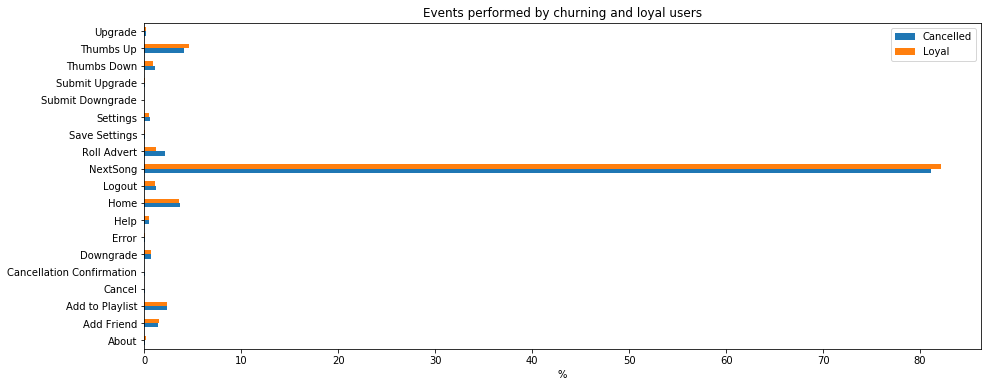

In [29]:
sparkify_pdf = sparkify_churn_df.toPandas()
churn_users = sparkify_pdf[sparkify_pdf.cancelled_user == 1].groupby(['page'])['userId'].count()
churn_users = churn_users/churn_users.sum()*100

loyal_users = sparkify_pdf[sparkify_pdf.cancelled_user == 0].groupby(['page'])['userId'].count()
loyal_users = loyal_users/loyal_users.sum()*100

plot_hist(churn_users, 'Cancelled', loyal_users, 'Loyal', 'Events performed by churning and loyal users', '%')

The '*NextSong*' event obviously occurs more frequently than the others and doesn't help much in differentiating **churning** and **loyal** users, so let's remove it from the plot to make it more clear. '*Downgrade*' and '*Cancel*' are redundant with their confirmation events, so they can also be removed from the plot.

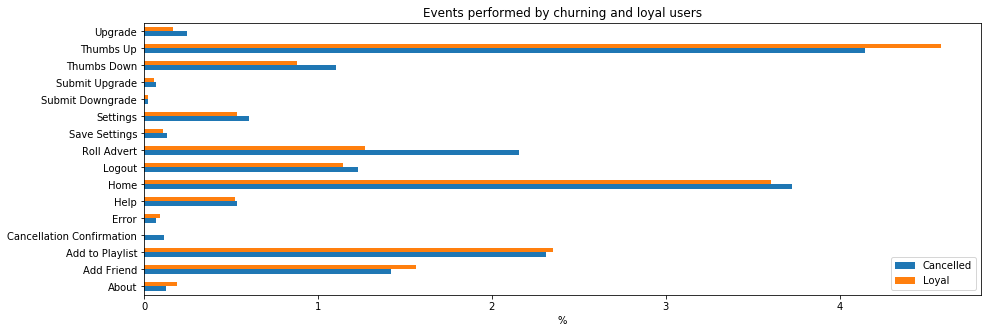

In [30]:
# Drop with a try/except to catch any KeyError if the label is not present
to_remove = ['Cancel', 'Downgrade', 'NextSong']

for lbl in to_remove:
    try:
        churn_users.drop(labels=lbl, inplace=True)
    except KeyError:
        continue

for lbl in to_remove:
    try:
        loyal_users.drop(labels=lbl, inplace=True)
    except KeyError:
        continue
        
plot_hist(churn_users, 'Cancelled', loyal_users, 'Loyal', 'Events performed by churning and loyal users', '%')

The plot above confirms that **churning** and **loyal** users' behavior varies. In particular, **churning** users tend to give more **'*Thumbs Down*'** and to **'*Roll Advert*'**, while **loyal** users give more **'*Thumbs Up*'**, **'*Add Friend*'** and visit the **'*About*'** page.

### Gender ###

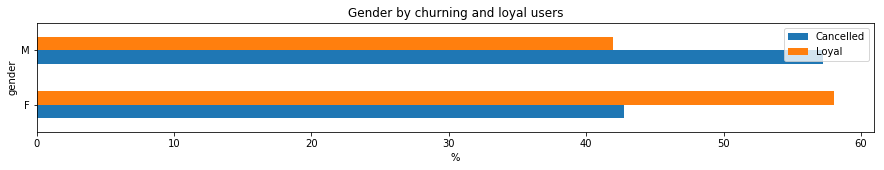

In [31]:
churn_users = sparkify_pdf[sparkify_pdf.cancelled_user == 1].groupby(['gender'])['userId'].count()
churn_users = churn_users/churn_users.sum()*100

loyal_users = sparkify_pdf[sparkify_pdf.cancelled_user == 0].groupby(['gender'])['userId'].count()
loyal_users = loyal_users/loyal_users.sum()*100

plot_hist(churn_users, 'Cancelled', loyal_users, 'Loyal', 'Gender by churning and loyal users', '%')

**'*Gender*'** has an obvious effect, as more **males churn** than **females**.

## Level ##

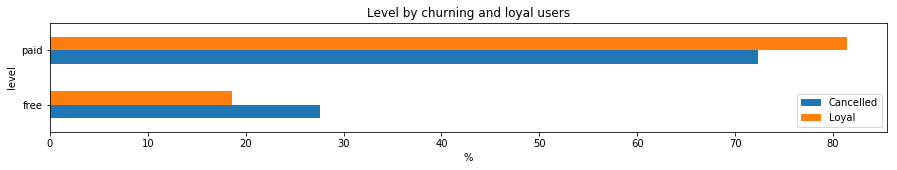

In [32]:
churn_users = sparkify_pdf[sparkify_pdf.cancelled_user == 1].groupby(['level'])['userId'].count()
churn_users = churn_users/churn_users.sum()*100

loyal_users = sparkify_pdf[sparkify_pdf.cancelled_user == 0].groupby(['level'])['userId'].count()
loyal_users = loyal_users/loyal_users.sum()*100

plot_hist(churn_users, 'Cancelled', loyal_users, 'Loyal', 'Level by churning and loyal users', '%')

Initially counterintuitive for me, it makes sense that **paying** users should stay **loyal** more than those who use the **free** service, since they chose to purchase the service at some point because they enjoyed using it, there's also some kind of "mental inertia" when you're financially bound to a subscription service, and finally **non-paying** users never have appreciated the service enough to pay for it (or have since downgraded) and are probably - as we saw above - annoyed with the ads.

## Time ##
As we saw above, we only have 63 days worth of data, so **'*ts_year*'**, **'*ts_month*'**, and **'*ts_week_#*'** won't be of much use here. **'*ts_date*'** won't be used either, but I keep it around to better visualize the date when looking at the data.

In [33]:
# Remove the ts_year, ts_month, and ts_week_# columns, which will not be used right now
sparkify_churn_df = sparkify_churn_df.drop('ts_year', 'ts_month', 'ts_week_#')

Let's visualize the possible effects of **'*ts_day*'**, **'*ts_weekday*'** and **'*ts_hour*'** on **churn**.

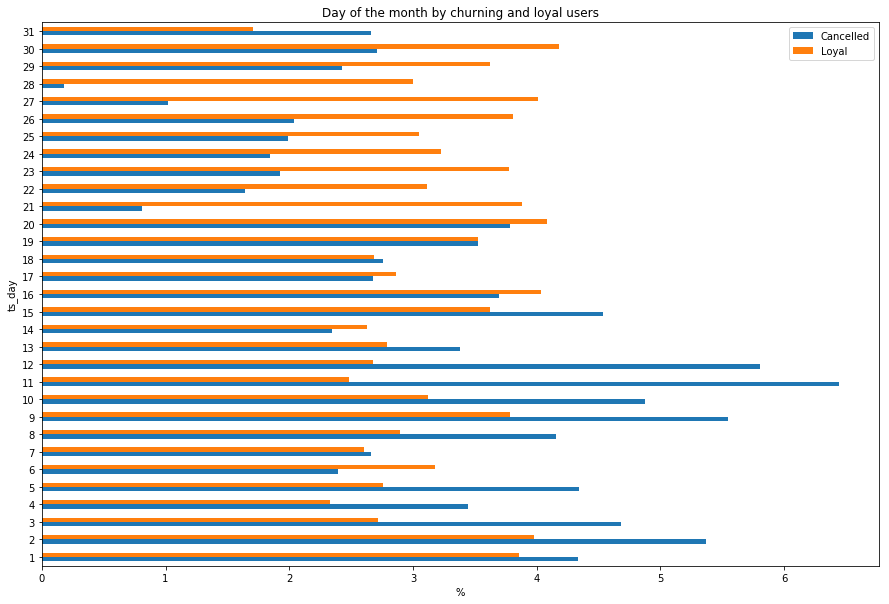

In [34]:
churn_users = sparkify_pdf[sparkify_pdf.cancelled_user == 1].groupby(['ts_day'])['userId'].count()
churn_users = churn_users/churn_users.sum()*100
churn_users.index = churn_users.index.map(int)
churn_users.sort_index(inplace=True)

loyal_users = sparkify_pdf[sparkify_pdf.cancelled_user == 0].groupby(['ts_day'])['userId'].count()
loyal_users = loyal_users/loyal_users.sum()*100
loyal_users.index = loyal_users.index.map(int)
loyal_users.sort_index(inplace=True)

plot_hist(churn_users, 'Cancelled', loyal_users, 'Loyal', 'Day of the month by churning and loyal users', '%')

There's definitely a trend here: **churning** users are much more active during the **1st half** of the **month**, while **loyal** users have a more **steady** usage rate throughout the month.

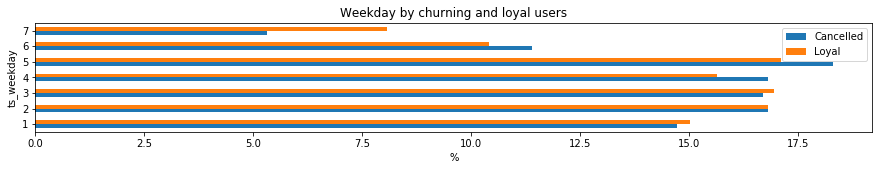

In [35]:
churn_users = sparkify_pdf[sparkify_pdf.cancelled_user == 1].groupby(['ts_weekday'])['userId'].count()
churn_users = churn_users/churn_users.sum()*100
churn_users.index = churn_users.index.map(int)
churn_users.sort_index(inplace=True)

loyal_users = sparkify_pdf[sparkify_pdf.cancelled_user == 0].groupby(['ts_weekday'])['userId'].count()
loyal_users = loyal_users/loyal_users.sum()*100
loyal_users.index = loyal_users.index.map(int)
loyal_users.sort_index(inplace=True)

plot_hist(churn_users, 'Cancelled', loyal_users, 'Loyal', 'Weekday by churning and loyal users', '%')

The **second half** of the **week** seems to reveal differences in behavior: **churners** tend to be slightly more active on **Thursday**, **Friday**, and **Saturday**, whereas **loyal** users are much more active on **Sunday**. Is there a correlation with the fact that they listen to music in a less stressful state of mind?...

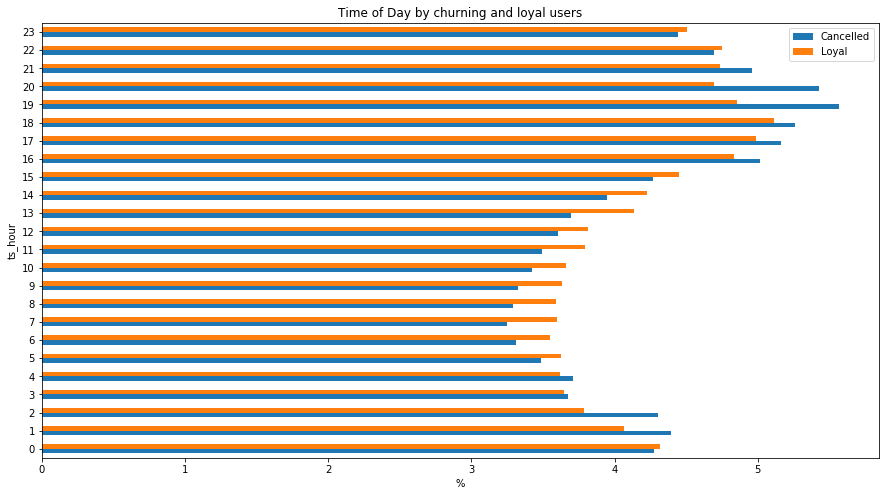

In [36]:
churn_users = sparkify_pdf[sparkify_pdf.cancelled_user == 1].groupby(['ts_hour'])['userId'].count()
churn_users = churn_users/churn_users.sum()*100
churn_users.index = churn_users.index.map(int)
churn_users.sort_index(inplace=True)

loyal_users = sparkify_pdf[sparkify_pdf.cancelled_user == 0].groupby(['ts_hour'])['userId'].count()
loyal_users = loyal_users/loyal_users.sum()*100
loyal_users.index = loyal_users.index.map(int)
loyal_users.sort_index(inplace=True)

plot_hist(churn_users, 'Cancelled', loyal_users, 'Loyal', 'Time of Day by churning and loyal users', '%')

**Loyal** users are more **active** at the **beginning** and **middle** of the **day**, whereas **churning** users tend to use the service in the **evening** and **late at night**. Without more information about the users, we can only take a few guesses, such as: maybe **loyal** users listen to music at work and **churning** users tend to be night owls; maybe they're a younger crowd?

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## Little Reminder ##
Let's refresh our memory and display the data we have so far.

In [37]:
sparkify_churn_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- userId: string (nullable = true)
 |-- ts_date: string (nullable = true)
 |-- ts_day: string (nullable = true)
 |-- ts_hour: string (nullable = true)
 |-- ts_weekday: string (nullable = true)
 |-- cancelled_user: integer (nullable = true)
 |-- downgraded_user: integer (nullable = true)



In [38]:
sparkify_churn_df.toPandas().head()

,artist,gender,itemInSession,length,level,page,registration,sessionId,song,ts,userId,ts_date,ts_day,ts_hour,ts_weekday,cancelled_user,downgraded_user
0,Sea Wolf,M,0,265.53424,paid,NextSong,1538159495000,9,Ses Monuments,1538965220000,10,2018-10-08,8,4,1,0,0
1,George Baker Selection,M,1,200.43710,paid,NextSong,1538159495000,9,Morning Sky,1538965485000,10,2018-10-08,8,4,1,0,0
2,Klaus Lage,M,2,208.03873,paid,NextSong,1538159495000,9,Du Hast'n Freund In Mir (You've Got A Friend In Me),1538965685000,10,2018-10-08,8,4,1,0,0
3,Dave Grusin,M,3,526.44526,paid,NextSong,1538159495000,9,Playera,1538965893000,10,2018-10-08,8,4,1,0,0
4,Blue Oyster Cult,M,4,272.06485,paid,NextSong,1538159495000,9,Burnin' For You,1538966419000,10,2018-10-08,8,4,1,0,0


## Creating new Features ##
I create new Features that I will then use to build the DataFrame that I want for Modeling:
- Gender (one-hot encoded)
- Page (one-hot encoding to calculate # of occurrences per type, for different time windows)
- Level (one-hot encoded, for different time windows: majority value if 2 levels during 1 window)
- Average Session Duration (for different time windows)
- Number of Sessions (for different time windows)
- Time since Registration (for different time windows)
- Number of Songs (for different time windows)
- Number of Artists (for different time windows)

### One-hot Encode Categorical Features ###

In [39]:
def one_hot_encode(df, feature_cols):
    stages = []
    
    for col in feature_cols:
        stringIndexer = StringIndexer(inputCol=col, outputCol='{}_Index'.format(col))
        encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=['{}_Vec'.format(col)])
        stages += [stringIndexer, encoder]
        
    pipeline = Pipeline(stages=stages)
    encoded_df = pipeline.fit(df).transform(df)
    
    return encoded_df

In [40]:
# One-hot encode the desired categorical features
cat_cols_to_one_hot_encode = ['gender', 'page', 'level']
sparkify_encoded_df = one_hot_encode(sparkify_churn_df, cat_cols_to_one_hot_encode)

In [41]:
# Display the resulting columns in light of the userId and sessionId
cat_cols_to_display = ['userId', 'sessionId']
for label in cat_cols_to_one_hot_encode:
    cat_cols_to_display += [label, '{}_Index'.format(label), '{}_Vec'.format(label)]
    
sparkify_encoded_df.select(cat_cols_to_display).toPandas().head(20)

,userId,sessionId,gender,gender_Index,gender_Vec,page,page_Index,page_Vec,level,level_Index,level_Vec
0,10,9,M,1.0,(0.0),NextSong,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",paid,0.0,(1.0)
1,10,9,M,1.0,(0.0),NextSong,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",paid,0.0,(1.0)
2,10,9,M,1.0,(0.0),NextSong,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",paid,0.0,(1.0)
3,10,9,M,1.0,(0.0),NextSong,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",paid,0.0,(1.0)
4,10,9,M,1.0,(0.0),NextSong,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",paid,0.0,(1.0)
5,10,9,M,1.0,(0.0),NextSong,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",paid,0.0,(1.0)
6,10,9,M,1.0,(0.0),NextSong,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",paid,0.0,(1.0)
7,10,9,M,1.0,(0.0),Thumbs Up,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",paid,0.0,(1.0)
8,10,9,M,1.0,(0.0),NextSong,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",paid,0.0,(1.0)
9,10,9,M,1.0,(0.0),NextSong,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",paid,0.0,(1.0)


### Aggregate the SparseVectors, first by sessionId and the by userId ###

In [42]:
sparkify_encoded_df.select(cat_cols_to_display).head()

Row(userId='10', sessionId=9, gender='M', gender_Index=1.0, gender_Vec=SparseVector(1, {}), page='NextSong', page_Index=0.0, page_Vec=SparseVector(18, {0: 1.0}), level='paid', level_Index=0.0, level_Vec=SparseVector(1, {0: 1.0}))

In [43]:
# First experimenting with Summarizer
sparkify_encoded_df.groupby(['userId', 'sessionId']) \
                   .agg(Summarizer.mean(sparkify_encoded_df.page_Vec).alias('mean_page')) \
                   .sort('userId').toPandas().head(10)

,userId,sessionId,mean_page
0,10,9,"[0.8142857142857143, 0.04285714285714286, 0.05714285714285714, 0.014285714285714285, 0.04285714285714286, 0.0, 0.014285714285714285, 0.0, 0.0, 0.014285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,10,1047,"[0.84, 0.08, 0.04, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,10,1414,"[0.8076923076923077, 0.0641025641025641, 0.038461538461538464, 0.0, 0.01282051282051282, 0.0, 0.02564102564102564, 0.0, 0.01282051282051282, 0.01282051282051282, 0.01282051282051282, 0.0, 0.0, 0.01282051282051282, 0.0, 0.0, 0.0, 0.0]"
3,10,1981,"[0.8842105263157894, 0.031578947368421054, 0.021052631578947368, 0.010526315789473684, 0.010526315789473684, 0.0, 0.021052631578947368, 0.0, 0.010526315789473684, 0.010526315789473684, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,10,1592,"[0.8589743589743589, 0.01282051282051282, 0.05128205128205128, 0.0, 0.01282051282051282, 0.01282051282051282, 0.02564102564102564, 0.0, 0.02564102564102564, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
5,10,595,"[0.8485523385300668, 0.051224944320712694, 0.035634743875278395, 0.015590200445434299, 0.011135857461024499, 0.0, 0.008908685968819599, 0.008908685968819599, 0.0066815144766146995, 0.008908685968819599, 0.0, 0.0, 0.004454342984409799, 0.0, 0.0, 0.0, 0.0, 0.0]"
6,100,683,"[0.71875, 0.0, 0.03125, 0.0625, 0.03125, 0.0, 0.03125, 0.03125, 0.03125, 0.03125, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0]"
7,100,2428,"[0.8901098901098901, 0.07692307692307693, 0.02197802197802198, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01098901098901099, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
8,100,1279,"[0.8387096774193549, 0.06451612903225806, 0.03225806451612903, 0.0, 0.03225806451612903, 0.0, 0.03225806451612903, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,100,369,"[0.8425925925925926, 0.05555555555555555, 0.027777777777777776, 0.009259259259259259, 0.037037037037037035, 0.0, 0.009259259259259259, 0.009259259259259259, 0.009259259259259259, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [44]:
# Aggregate page view vectors mean/variance/count per session
summarizer = Summarizer.metrics('mean', 'variance', 'count')
sparkify_cat_df = sparkify_encoded_df.groupby(['userId', 'sessionId']) \
                                     .agg(summarizer.summary(sparkify_encoded_df.page_Vec).alias('page_stats_session')) \
                                     .sort('userId')
sparkify_cat_df.toPandas().head(10)

,userId,sessionId,page_stats_session
0,10,9,"([0.8142857142857143, 0.04285714285714286, 0.05714285714285714, 0.014285714285714285, 0.04285714285714286, 0.0, 0.014285714285714285, 0.0, 0.0, 0.014285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.153416149068323, 0.04161490683229814, 0.0546583850931677, 0.014285714285714287, 0.04161490683229814, 0.0, 0.014285714285714287, 0.0, 0.0, 0.014285714285714287, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 70)"
1,10,1047,"([0.84, 0.08, 0.04, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.13999999999999999, 0.07666666666666667, 0.04, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 25)"
2,10,1414,"([0.8076923076923077, 0.0641025641025641, 0.038461538461538464, 0.0, 0.01282051282051282, 0.0, 0.02564102564102564, 0.0, 0.01282051282051282, 0.01282051282051282, 0.01282051282051282, 0.0, 0.0, 0.01282051282051282, 0.0, 0.0, 0.0, 0.0], [0.15734265734265734, 0.060772560772560776, 0.037462537462537464, 0.0, 0.012820512820512822, 0.0, 0.025308025308025308, 0.0, 0.012820512820512822, 0.012820512820512822, 0.012820512820512822, 0.0, 0.0, 0.012820512820512822, 0.0, 0.0, 0.0, 0.0], 78)"
3,10,1981,"([0.8842105263157894, 0.031578947368421054, 0.021052631578947368, 0.010526315789473684, 0.010526315789473684, 0.0, 0.021052631578947368, 0.0, 0.010526315789473684, 0.010526315789473684, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.10347144456886898, 0.030907054871220606, 0.020828667413213885, 0.010526315789473684, 0.010526315789473684, 0.0, 0.020828667413213885, 0.0, 0.010526315789473684, 0.010526315789473684, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 95)"
4,10,1592,"([0.8589743589743589, 0.01282051282051282, 0.05128205128205128, 0.0, 0.01282051282051282, 0.01282051282051282, 0.02564102564102564, 0.0, 0.02564102564102564, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.12271062271062272, 0.012820512820512822, 0.04928404928404928, 0.0, 0.012820512820512822, 0.012820512820512822, 0.025308025308025308, 0.0, 0.025308025308025308, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 78)"
5,10,595,"([0.8485523385300668, 0.051224944320712694, 0.035634743875278395, 0.015590200445434299, 0.011135857461024499, 0.0, 0.008908685968819599, 0.008908685968819599, 0.0066815144766146995, 0.008908685968819599, 0.0, 0.0, 0.004454342984409799, 0.0, 0.0, 0.0, 0.0, 0.0], [0.12879812281259942, 0.04870943366210627, 0.034441616290168627, 0.01538140311804009, 0.011036430162265352, 0.0, 0.00884902958956411, 0.00884902958956411, 0.006651686286986955, 0.00884902958956411, 0.0, 0.0, 0.004444400254533885, 0.0, 0.0, 0.0, 0.0, 0.0], 449)"
6,100,683,"([0.71875, 0.0, 0.03125, 0.0625, 0.03125, 0.0, 0.03125, 0.03125, 0.03125, 0.03125, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0], [0.2086693548387097, 0.0, 0.03125, 0.06048387096774194, 0.03125, 0.0, 0.03125, 0.03125, 0.03125, 0.03125, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0], 32)"
7,100,2428,"([0.8901098901098901, 0.07692307692307693, 0.02197802197802198, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01098901098901099, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.09890109890109891, 0.07179487179487179, 0.021733821733821733, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01098901098901099, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 91)"
8,100,1279,"([0.8387096774193549, 0.06451612903225806, 0.03225806451612903, 0.0, 0.03225806451612903, 0.0, 0.03225806451612903, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.13978494623655913, 0.06236559139784946, 0.03225806451612903, 0.0, 0.03225806451612903, 0.0, 0.03225806451612903, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 31)"
9,100,369,"([0.8425925925925926, 0.05555555555555555, 0.027777777777777776, 0.009259259259259259, 0.037037037037037035, 0.0, 0.009259259259259259, 0.009259259259259259, 0.009259259259259259, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.13386985115957079, 0.052959501557632405, 0.027258566978193146, 0.009259259259259259, 0.035998615437867774, 0.0, 0.009259259259259259, 0.009259259

In [45]:
sparkify_cat_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- page_stats_session: struct (nullable = false)
 |    |-- mean: vector (nullable = false)
 |    |-- variance: vector (nullable = false)
 |    |-- count: long (nullable = false)



In [46]:
# Aggregate page view vector mean per user
summarizer = Summarizer.metrics('mean')
sparkify_cat_df = sparkify_cat_df.groupby(['userId']) \
                                 .agg(summarizer.summary(sparkify_cat_df.page_stats_session.mean),
                                      summarizer.summary(sparkify_cat_df.page_stats_session.variance),
                                      Fmean(sparkify_cat_df.page_stats_session.count)) \
                                 .alias('page_stats_user') \
                                 .sort('userId')
sparkify_cat_df.toPandas().head(10)

,userId,"aggregate_metrics(page_stats_session[mean], 1.0)","aggregate_metrics(page_stats_session[variance], 1.0)",avg(page_stats_session[count])
0,10,"([0.8422858742997061, 0.04709735191155892, 0.04059563705677877, 0.006733705086770378, 0.021693390291444445, 0.0021367521367521365, 0.015921513852588758, 0.0014847809948032665, 0.00927822812127114, 0.007756871477420065, 0.0021367521367521365, 0.0, 0.0007423904974016332, 0.0021367521367521365, 0.0, 0.0, 0.0, 0.0],)","([0.13428983275051193, 0.04524852260422754, 0.039445875923856163, 0.006698905532204677, 0.021469779737510467, 0.002136752136752137, 0.01576324365075715, 0.0014748382649273518, 0.009217756700833128, 0.007746928747544149, 0.002136752136752137, 0.0, 0.0007407333757556474, 0.002136752136752137, 0.0, 0.0, 0.0, 0.0],)",132.500000
1,100,"([0.7865218851667545, 0.05099065863368159, 0.07710960199509596, 0.0189345232026729, 0.013593883080959763, 0.007352543089256311, 0.01741848358030277, 0.0047897168458575215, 0.005987985244803801, 0.004273941915618187, 0.005384218511573801, 0.0003322259136212624, 0.003509142545293492, 0.002692050210567463, 0.0006856316309218122, 0.0003322259136212624, 9.128251939753537e-05, 0.0],)","([0.15111514967177972, 0.04950032046513035, 0.04756062228866214, 0.018651095501510465, 0.013420850508651818, 0.007164018543315122, 0.01686494819453066, 0.004744279666641874, 0.00595091485121972, 0.004253848746537566, 0.005272640529611446, 0.0003322259136212624, 0.0035016908525498025, 0.0026741483129663172, 0.0006856316309218122, 0.0003322259136212624, 9.128251939753537e-05, 0.0],)",91.828571
2,100001,"([0.6887123396999872, 0.03704812174638587, 0.06653289437884312, 0.013844298126281039, 0.010221109720483939, 0.07826404382289456, 0.04316332916145181, 0.008525149190110827, 0.0, 0.0036231884057971015, 0.0125, 0.007246376811594203, 0.0, 0.0, 0.005319148936170213, 0.0, 0.0, 0.0125],)","([0.21678652472722865, 0.035340824581451456, 0.06361537448125948, 0.013844298126281039, 0.010221109720483939, 0.07369055904167013, 0.04188129183218153, 0.008525149190110827, 0.0, 0.0036231884057971015, 0.012499999999999999, 0.007139812446717818, 0.0, 0.0, 0.005319148936170213, 0.0, 0.0, 0.012499999999999999],)",46.750000
3,100002,"([0.8120813397129186, 0.016626794258373205, 0.0666267942583732, 0.05526315789473685, 0.0013157894736842105, 0.013995215311004785, 0.011363636363636364, 0.0, 0.022727272727272728, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],)","([0.14522290574922153, 0.01654325206956786, 0.06654325206956786, 0.055179615705931495, 0.0013157894736842105, 0.01398129161287056, 0.011363636363636364, 0.0, 0.021645021645021644, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],)",54.500000
4,100003,"([0.8223684210526316, 0.019736842105263157, 0.046052631578947366, 0.013157894736842105, 0.0, 0.05921052631578947, 0.019736842105263157, 0.0, 0.0, 0.0, 0.006578947368421052, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006578947368421052],)","([0.11605263157894738, 0.019210526315789477, 0.04236842105263158, 0.012982456140350878, 0.0, 0.052894736842105265, 0.019210526315789477, 0.0, 0.0, 0.0, 0.006578947368421052, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006578947368421052],)",39.000000
5,100004,"([0.6873768838144122, 0.04387299413550394, 0.11641360567084334, 0.012056583801097628, 0.01815484055181944, 0.05079826780758611, 0.017991679809070373, 0.014775177296640178, 0.007711801686933424, 0.017758487646850018, 0.002744121513542584, 0.0033880621789741396, 0.0, 0.004785247432306256, 0.0005628528436796434, 0.0009438191377749055, 0.0006655746729659361, 0.0],)","([0.2060092349275646, 0.04342382008778069, 0.06581072122078374, 0.011739824033893075, 0.017833858353418882, 0.04684324266797082, 0.0177737901772599, 0.014730404735439332, 0.0076634903542343565, 0.01775078129170635, 0.0027376699422623986, 0.0033836067601046753, 0.0, 0.004785247432306256, 0.0005628528436796434, 0.0009438191377749057, 0.0006655746729659361, 0.0],)",59.285714
6,100005,"([0.5739954616666946, 0.02071938715774332, 0.2529485228115365, 0.008654055229397694, 0.00

## Building the Modeling DataFrame ##
I join all elements extracted above by **'*userId*'** into one DataFrame that will be used next for Modeling.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.